In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [103]:
# Load in dataset
train_file_path = 'THA2train.xlsx'
validate_file_path = 'THA2validate.xlsx'
train_dataset = pd.read_excel(train_file_path)
validate_dataset = pd.read_excel(validate_file_path)

X_train = train_dataset[['X_0', 'X_1']].values
y_train = train_dataset['y'].values.reshape(-1, 1)
X_val = validate_dataset[['X_0', 'X_1']].values
y_val = validate_dataset['y'].values.reshape(-1, 1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [104]:
#Activation functions
def sigmoid( x): # sigmoid function used at the hidden layer and output layer
    return 1 / (1 + np.exp(-x))
def tanh(x):     # hyperbolic tangent
    return np.tanh(x)
def relu(x):     #RELU
    return np.maximum(0, x)
def leaky_relu(x, alpha=0.01):   #Leaky RELU
    return np.where(x > 0, x, alpha * x)
def elu(x, alpha=1.0):    #exponential LU
    return np.where(x > 0, x, alpha * (np.exp(x) - 1))

#Derivative of activation functions
def sigmoid_derivative( x): # sigmoid derivative used for backpropgation
    return sigmoid(x) * (1 - sigmoid(x))
def tanh_derivative(x):
    return 1 - np.tanh(x)**2
def relu_derivative(x):
    return np.where(x > 0, 1, 0)
def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)
def elu_derivative(x, alpha=1.0):
    return np.where(x > 0, 1, alpha * np.exp(x))

In [118]:
np.random.seed(42)

class MLP:
    def __init__(self, input_size = 2, hidden1_size = 10, hidden2_size = 10, output_size = 2):
        #initialize parameters
        self.input_size = input_size
        self.hidden1_size = hidden1_size
        self.hidden2_size = hidden2_size
        self.output_size = output_size

        # initialize weights randomly
        self.weights1 = np.random.randn(self.input_size, self.hidden1_size)
        self.weights2 = np.random.randn(self.hidden1_size, self.hidden2_size)
        self.weights3 = np.random.randn(self.hidden2_size, self.output_size)
        
#         #initialize weights to zero
#         self.weights1 = np.zeros((self.input_size, self.hidden1_size))
#         self.weights2 = np.zeros((self.hidden1_size, self.hidden2_size))
#         self.weights3 = np.zeros((self.hidden2_size, self.output_size))

        # initialize biases to 0
        self.bias1 = np.zeros((1, self.hidden1_size))
        self.bias2 = np.zeros((1, self.hidden2_size))
        self.bias3 = np.zeros((1, self.output_size))

    def forwardPropogation(self, X):
        #Activation of hidden layer 1
        hidden_layer1 = relu(X.dot(self.weights1) + self.bias1)
        #Activation of hidden layer 2
        hidden_layer2 = relu(hidden_layer1.dot(self.weights2) + self.bias2)
        #Activation of output layer
        output_layer = sigmoid(hidden_layer2.dot(self.weights3) + self.bias3)
        return hidden_layer1, hidden_layer2, output_layer
        
    def backwardPropogation(self,X,y, activation1, activation2, activation3):
        #derivative weights and biases for output layer
        error = activation3 - y
        d_weights3 = activation2.T.dot(error * sigmoid_derivative(activation3))
        d_bias3 = np.sum(error * sigmoid_derivative(activation3), axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 2
        error_hidden2 = error.dot(self.weights3.T) * relu_derivative(activation2)
        d_weights2 = activation1.T.dot(error_hidden2)
        d_bias2 = np.sum(error_hidden2, axis=0, keepdims=True)

        #derivative weights and biases for hidden layer 1
        error_hidden1 = error_hidden2.dot(self.weights2.T) * relu_derivative(activation1)
        d_weights1 = X.T.dot(error_hidden1)
        d_bias1 = np.sum(error_hidden1, axis=0, keepdims=True)
        return d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3
    
    def updateParams(self, d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate):
        self.weights3 -= learning_rate * d_weights3
        self.bias3 -= learning_rate * d_bias3
        self.weights2 -= learning_rate * d_weights2
        self.bias2 -= learning_rate * d_bias2
        self.weights1 -= learning_rate * d_weights1
        self.bias1 -= learning_rate * d_bias1
        
    #Binary cross entropy
    def bce(self, y_true, y_pred):
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    #Train the model
    def train(self, X, y, epochs=100, learning_rate =0.01):
        train_loss_history = []
        output_result = []

        for epoch in range(epochs):
            # forward propogation
            hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X)
            output_result.append(output_layer)

            # Backpropagation
            d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3 = self.backwardPropogation(X,y, hidden_layer1, hidden_layer2, output_layer)
            

            # Update weights and biases
            self.updateParams(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate)

            #Training loss
            train_loss = self.bce(y_train, output_layer)
            train_loss_history.append(train_loss)
            
            y_train_pred = np.round(output_layer)
            accuracy = np.mean(y_train_pred == y)
            
            if epoch%(epochs/10) == 0:
                print(f"Epoch {epoch+1} Error {train_loss} Accuracy {accuracy:.2f}")
                #print("Epoch: "+str(epoch+1) + " Error: "+str(train_loss) + " Accuracy: "+str(accuracy))
                
                     
        print('Training Complete')
        print('----------------------------------------------------------------------------')
        return train_loss_history

    #Test the model
    def test(self, X_val, y_val):
        output_result = []
        
        hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_val)

        # Compute validation loss
        val_loss = self.bce(y_val, output_layer)
        #val_loss_history.append(val_loss)
            
        y_val_pred = np.round(output_layer)
        accuracy = np.mean(y_val_pred == y_val)
        
        output_result.append(y_val_pred)
        
        # Confusion matrix
        confusion_matrix = np.zeros((2, 2))
        confusion_matrix[0, 0] = np.sum((y_val == 0) & (y_val_pred == 0))
        confusion_matrix[0, 1] = np.sum((y_val == 0) & (y_val_pred == 1))
        confusion_matrix[1, 0] = np.sum((y_val == 1) & (y_val_pred == 0))
        confusion_matrix[1, 1] = np.sum((y_val == 1) & (y_val_pred == 1))
        
        return accuracy, val_loss, confusion_matrix
        

#         # Check for early stopping based on validation loss
#         if len(val_loss_history) > 100 and val_loss_history[-1] > np.mean(val_loss_history[-10:]):
#             print("Stopping early as validation loss is not improving.")
#             break
    
    def model(self, X, y, X_val, y_val, epochs=100, learning_rate =0.01):
        train_loss_history = []
        val_loss_history = []
        output_result = []
        batch_size = 32

        for epoch in range(epochs):
            for i in range(0, len(X), batch_size):
                #Batch
                X_train = X[i : i + batch_size]
                y_train = y[i : i + batch_size]
                
                # forward propogation
                hidden_layer1, hidden_layer2, output_layer = self.forwardPropogation(X_train)
                output_result.append(output_layer)

                # Backpropagation
                d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3 = self.backwardPropogation(X_train,y_train, hidden_layer1, hidden_layer2, output_layer)
            

                # Update weights and biases
                self.updateParams(d_weights1, d_weights2, d_weights3, d_bias1, d_bias2, d_bias3, learning_rate)

                #Training loss
                train_loss = self.bce(y_train, output_layer)
                
            train_loss_history.append(train_loss)
            
            y_train_pred = np.round(output_layer)
            train_accuracy = np.mean(y_train_pred == y_train)
                
            #Test the data
            val_accuracy, val_loss, confusion_matrix = self.test(X_val, y_val)
            val_loss_history.append(val_loss)
            
            if epoch%(epochs/10) == 0:
                print(f"Epoch {epoch+1} Training loss {train_loss} Train Accuracy {train_accuracy:.2f} Validation loss {val_loss} Validation Accuracy {val_accuracy:2f}")
        
        print("Confusion Matrix:")
        print(confusion_matrix)
        
        # Plot training and validation loss
        plt.plot(train_loss_history, label="Training Loss")
        plt.plot(val_loss_history, label="Validation Loss")
        plt.title("Training and Validation Loss over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

        print(f"Final accuracy of the model is: {val_accuracy:.2f}")

        

Epoch 1 Training loss 0.7394548132798444 Train Accuracy 0.75 Validation loss 0.9608296083117936 Validation Accuracy 0.682927
Epoch 51 Training loss 0.203401895299388 Train Accuracy 0.96 Validation loss 0.16777630719791792 Validation Accuracy 0.969512
Epoch 101 Training loss 0.1596886383039361 Train Accuracy 0.96 Validation loss 0.139729972186173 Validation Accuracy 0.975610
Epoch 151 Training loss 0.15138401717465838 Train Accuracy 0.96 Validation loss 0.1322592868272761 Validation Accuracy 0.975610
Epoch 201 Training loss 0.1472327985157835 Train Accuracy 0.96 Validation loss 0.12855829574136496 Validation Accuracy 0.975610
Epoch 251 Training loss 0.14480561663426073 Train Accuracy 0.96 Validation loss 0.12673472933010263 Validation Accuracy 0.975610
Epoch 301 Training loss 0.1459172825637905 Train Accuracy 0.96 Validation loss 0.125897614442722 Validation Accuracy 0.975610
Epoch 351 Training loss 0.14722752759120578 Train Accuracy 0.96 Validation loss 0.12617018078048015 Validation A

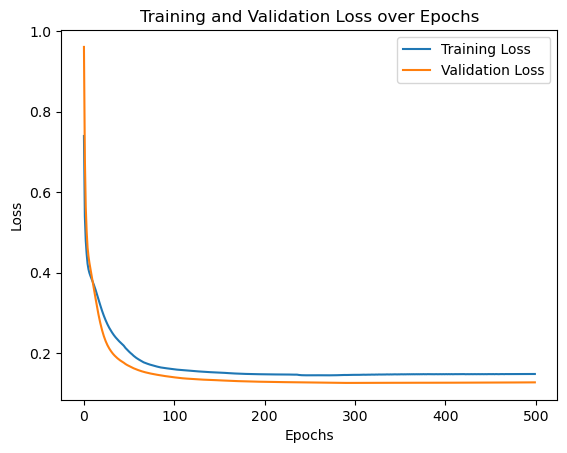

Final accuracy of the model is: 0.98


In [116]:
#Part A with relu for two hidden layers and sigmoid for output layer
mlp1 = MLP()
mlp1.model(X_train, y_train, X_val, y_val, epochs=500, learning_rate =0.001)

### Part B
#### 1. Parameter initialization. Choose the best performing model from Part A in terms of
#### classification accuracy. For this model, initialize all its parameters (connection weights and biases)
#### to zero and retrain it using all the other settings from Part A. Report the performance (e.g.
#### loss function over training epochs, classification accuracy and confusion matrix on the validation
#### set after training) of this new trained model. Do you observe any interesting behavior for this
#### new trained model? Discuss the performance of this new trained model in comparison with the
#### performance of the best model from Part A.

Epoch 1 Training loss 0.6931562121340573 Train Accuracy 0.46 Validation loss 0.6931471805600108 Validation Accuracy 0.500000
Epoch 51 Training loss 0.6931554109748652 Train Accuracy 0.46 Validation loss 0.6931471806176797 Validation Accuracy 0.500000
Epoch 101 Training loss 0.6931551710166518 Train Accuracy 0.46 Validation loss 0.6931471806559397 Validation Accuracy 0.500000
Epoch 151 Training loss 0.693155099141362 Train Accuracy 0.46 Validation loss 0.6931471806692834 Validation Accuracy 0.500000
Epoch 201 Training loss 0.6931550776119706 Train Accuracy 0.46 Validation loss 0.6931471806734495 Validation Accuracy 0.500000
Epoch 251 Training loss 0.6931550711630609 Train Accuracy 0.46 Validation loss 0.6931471806747123 Validation Accuracy 0.500000
Epoch 301 Training loss 0.6931550692313522 Train Accuracy 0.46 Validation loss 0.693147180675092 Validation Accuracy 0.500000
Epoch 351 Training loss 0.6931550686527271 Train Accuracy 0.46 Validation loss 0.6931471806752058 Validation Accurac

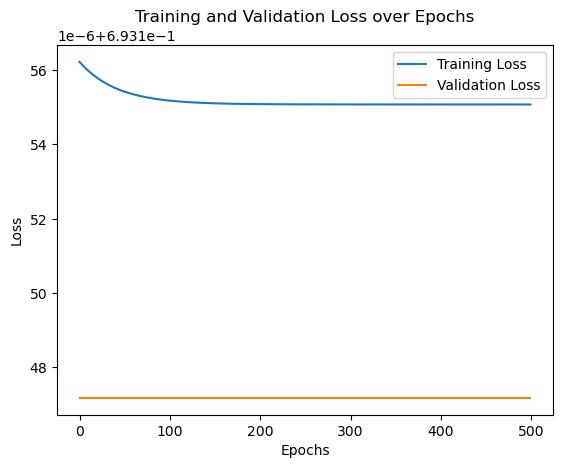

Final accuracy of the model is: 0.50


In [119]:
# After making connection weights and biases zero calling model function
mlp2 = MLP()
mlp2.model(X_train, y_train, X_val, y_val, epochs=500, learning_rate =0.001)